In [1]:
import glob
import xarray as xr
import numpy as np
import cmocean
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib import path, colors
from matplotlib.patches import Circle, Polygon
import skimage.io as io
from scipy import stats
import pandas as pd
from datetime import datetime, timedelta
from scipy.ndimage import generic_filter
import numba as nb
from scipy.interpolate import RegularGridInterpolator
from os.path import exists

In [2]:
from caribbean_map import *

In [3]:
%load_ext autoreload
%autoreload 2

import beachings

In [207]:
criteria = "c1"

if not exists(f'particles_stats_{criteria}.csv'):
    fid = open(f'particles_stats_{criteria}.csv', 'w')
    
    for year in range(2010, 2022):
        for month in range(1,13):
            file = f'../data/output/cm_mpw/cm_mpw_{year}-{month:02d}-01.nc'

            ds = xr.open_dataset(file)
            lon = ds.lon.values
            lat = ds.lat.values
            nb_traj, nb_obs = lon.shape
            #origin_date = datetime(2010,1,1)

            ds_origin = pd.read_csv(f'releases/particles_info_{year}{month:02d}01.csv', parse_dates=['date'])

            # distance
            d = beachings.haversine(lon, lat)

            # identify beaching

            if criteria == "c1":
                # considered beach if it travels less 100km in the past 30 days
                threshold_distance = 100*1000 # [m]
                period = 30  # [days]

                b_idx = np.zeros(nb_traj, dtype=int)
                for i in range(0, nb_traj):
                    b_idx[i] = beachings.identify_beaching_c1(d[i], threshold_distance, period)

            # c2
            if criteria == "c2":
                # considered beach if it travels less than 3km for 30 days in a row
                threshold_distance = 3000 # [m]
                period = 30  # [days]

                b_idx = np.zeros(nb_traj, dtype=int)
                for i in range(0, nb_traj):
                    b_idx[i] = beachings.identify_beaching_c2(d[i], threshold_distance, period)

            # c3
            if criteria == "c3":
                threshold_distance = -8  # km 
                probability = 1-0.5**(1/5)
                delay = 30  # days
                b_idx = beachings.identify_beaching_c3(d, probability, threshold_distance, delay)

            alive = b_idx == -99999

            # 0: beached, 1: ocean in region 2: ocean out region
            value = np.full(alive.shape, 2)
            value[~alive] = 0
            value[np.logical_and(alive, np.isfinite(lon[:,-1]))] = 1

            # write to file
            np.savetxt(fid, value, fmt='%d', newline = ",")
            fid.write(f'\n')

            # print to see progress
            print(f"{year}/{month}: Beached {np.sum(value==0)}, In {np.sum(value==1)}, Out {np.sum(value==2)}")

    fid.close()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(ds1.days, 100, alpha=0.5);
ax.hist(ds3.days, 100, alpha=0.5);
ax.set_xlim([0, 500])

In [9]:
np.percentile(ds1.days, 99)

536.0

In [10]:
np.percentile(ds3.days, 99)

502.0

In [6]:
for ds in [ds1, ds3]:
    print(ds.days.mean())
    print(ds.days.std())

103.80866536597836
112.37155487612655
87.09989120507248
99.65164035930421


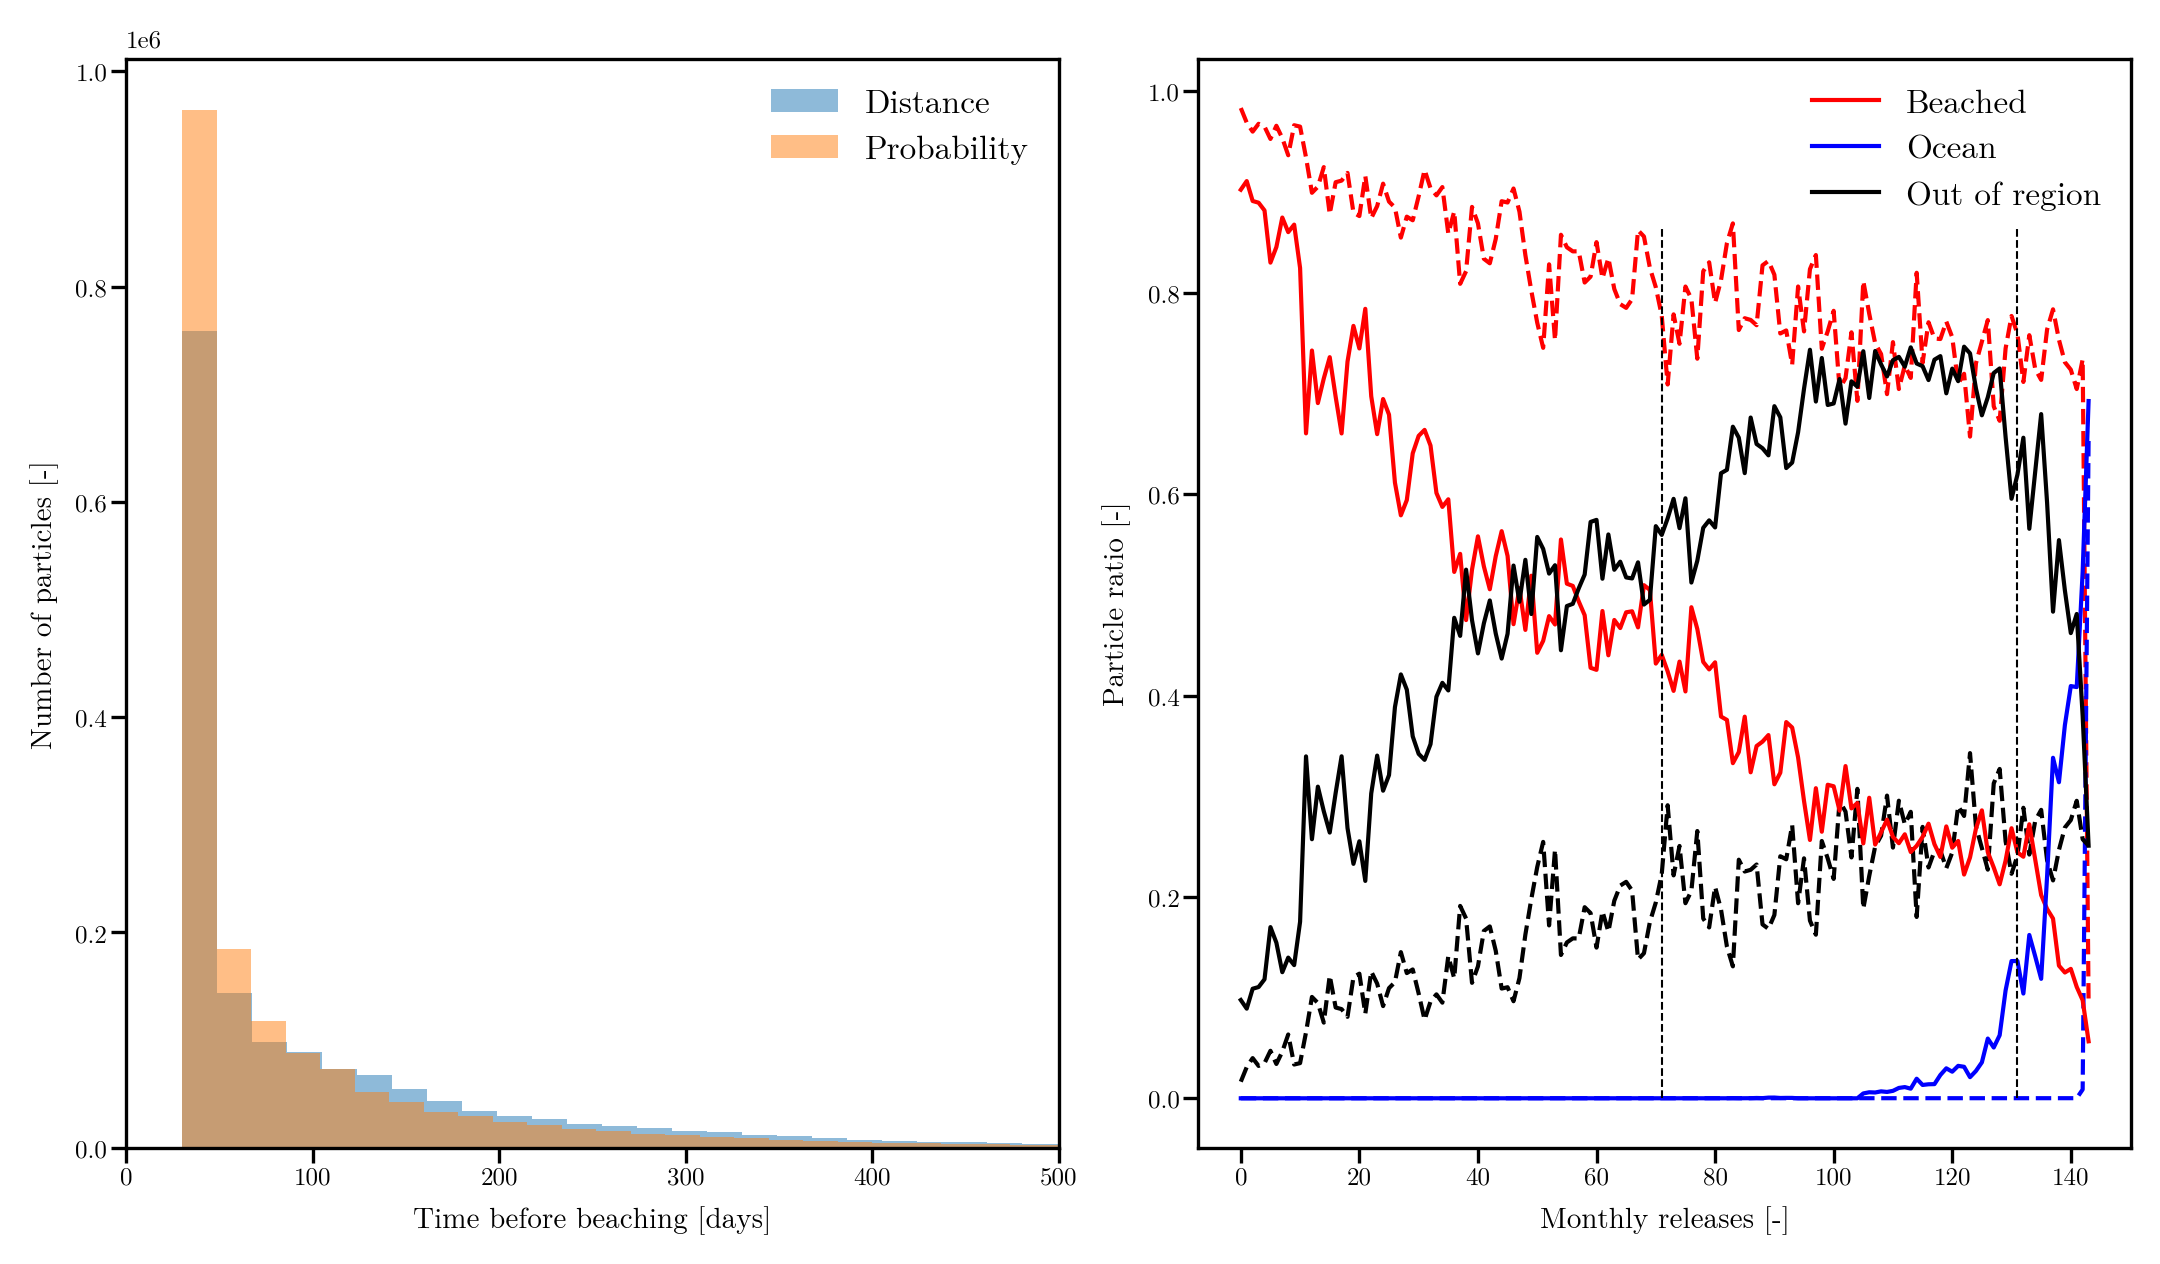

In [29]:
fig = plt.figure(dpi=300, figsize=fs)

ax0 = fig.add_subplot(1,2,1)
ax0.hist(ds1.days, 100, alpha=0.5, label="Distance");
ax0.hist(ds3.days, 100, alpha=0.5, label="Probability");
ax0.set_xlim([0, 500])

ax0.set_xlabel("Time before beaching [days]")
ax0.set_ylabel("Number of particles [-]")

plt.legend(frameon=False, fontsize=8)

ax = fig.add_subplot(1,2,2)

filenames = ["particles_stats_c3.csv", "particles_stats_c1.csv"]
styles = ["dashed", "solid"]
for i, filename in enumerate(filenames):
    with open(filename) as f:
        data = f.readlines()

        # 0: beached, 1: ocean in region 2: ocean out region
        stats = np.zeros((len(data), 3))

        for j, line in enumerate(data):
            line = np.array(list(map(int, line.split(',')[:-1])))
            stats[j, 0] = sum(line == 0)/len(line)
            stats[j, 1] = sum(line == 1)/len(line)
            stats[j, 2] = sum(line == 2)/len(line)

    ax.plot(stats[:,0], lw=1, ls=styles[i], c='red', label="Beached")
    ax.plot(stats[:,1], lw=1, ls=styles[i], c='blue', label="Ocean")
    ax.plot(stats[:,2], lw=1, ls=styles[i], c='k',label="Out of region")
    

ax.vlines(143-12, 0, 0.95*np.max(stats), color='k', lw=0.5, ls="dashed")
ax.vlines(143-6*12, 0, 0.95*np.max(stats), color='k', lw=0.5, ls="dashed")

ax.set_xlabel("Monthly releases [-]")
ax.set_ylabel("Particle ratio [-]")
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), frameon=False, fontsize=8)
fig.savefig(f'figures/beaching_stats.png', bbox_inches='tight', format='png', dpi=600)

In [142]:
fid = open(f'particles_stats.csv', 'a')

np.savetxt(fid, value, fmt='%d', newline = ",")
fid.close()

In [126]:
value = np.full(alive.shape, 2)
value[~alive] = 0
value[alive][np.isnan(lon[alive,-1])] = 1

In [ ]:
i = 10
beachings.identify_beaching_c1(d[i], threshold_distance, period)

-99999

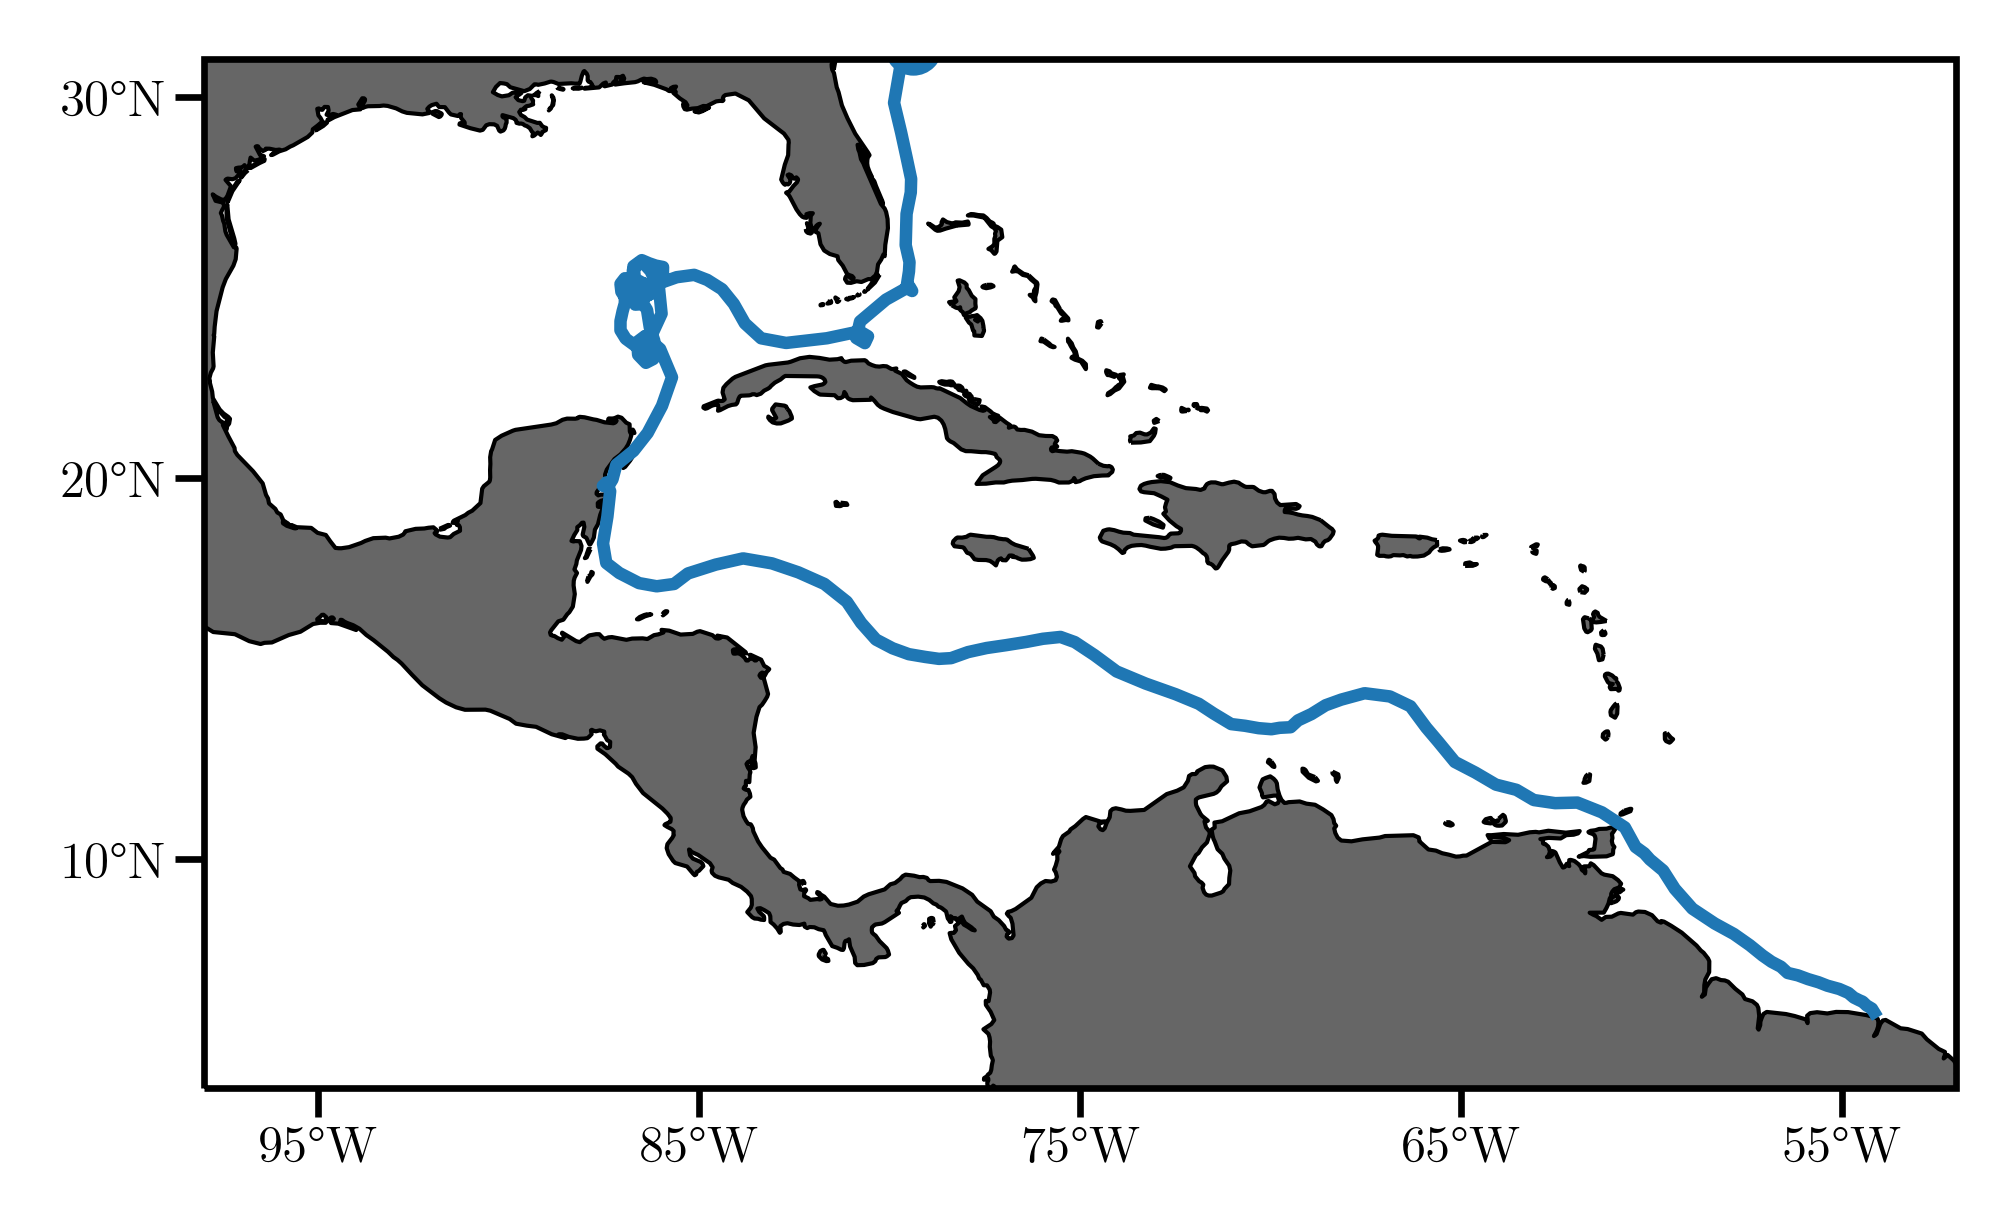

In [84]:
fig = plt.figure(dpi=600, figsize=fsh)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

geo_map(ax)

ax.plot(lon[i,:], lat[i,:])
ax.scatter(lon[i,np.isfinite(lon[i,:])][-1], lat[i,np.isfinite(lon[i,:])][-1])

In [5]:
criteria = 'c1'

if not exists(f'beachings_{criteria}.csv'):
    f = open(f'beachings_{criteria}.csv', 'w')
    f.write("release, land, cid0, lon0, lat0, mass0, days, cid1, lon1, lat1, mass1\n")
    f.close()

    for year in range(2010, 2022):
        for month in range(1,13):
            file = f'../data/output/cm_mpw/cm_mpw_{year}-{month:02d}-01.nc'

            ds = xr.open_dataset(file)
            lon = ds.lon.values
            lat = ds.lat.values
            nb_traj, nb_obs = lon.shape
            #origin_date = datetime(2010,1,1)

            ds_origin = pd.read_csv(f'releases/particles_info_{year}{month:02d}01.csv', parse_dates=['date'])

            # distance
            d = beachings.haversine(lon, lat)

            # identify beaching
            b_idx = np.zeros(nb_traj, dtype=int)

            # a drifters is considered beach if it travels less 100km in the past 30 days
            threshold_distance = 100*1000 # [m]
            period = 30  # [days]

            for i in range(0, nb_traj):
                b_idx[i] = beachings.identify_beaching_c1(d[i], threshold_distance, period)
    
            beached = b_idx != -99999

            land = np.hstack((np.ones(11315, dtype='bool'), np.zeros(len(lon)-11315, dtype='bool')))[beached]
            lon0 = ds_origin.loc[beached]['longitude'].values
            lat0 = ds_origin.loc[beached]['latitude'].values
            lon1 = lon[beached, b_idx[beached]]
            lat1 = lat[beached, b_idx[beached]]

            b_release = ds_origin.loc[beached]['date'].dt.strftime('%Y-%m-%d').values
            b_time = b_idx[beached]  # days 

            m0 = ds_origin.loc[beached]['weight [ton]'].values
            m1 = beachings.decay(m0, b_time/365)

            cid_0 = ds_origin.loc[beached]['country id'].values
            cid_1 = beachings.global_country_id(lon1, lat1)

            # append to csv
            fid = open(f'beachings_{criteria}.csv', 'a')
            np.savetxt(fid, np.column_stack((b_release.astype(object), land, cid_0, lon0, lat0, m0, b_time, cid_1, lon1, lat1, m1)), 
                       fmt='%s, %d, %d, %.10f, %.10f, %.3f, %d, %d, %.10f, %.10f, %.3f',
                       delimiter=', ', newline ='\n')
            fid.close()

In [42]:
criteria = 'c2'

if not exists(f'beachings_{criteria}.csv'):
    f = open(f'beachings_{criteria}.csv', 'w')
    f.write("release, land, cid0, lon0, lat0, mass0, days, cid1, lon1, lat1, mass1\n")
    f.close()

    for year in range(2010, 2022):
        for month in range(1,13):
            file = f'../data/output/cm_mpw/cm_mpw_{year}-{month:02d}-01.nc'

            ds = xr.open_dataset(file)
            lon = ds.lon.values
            lat = ds.lat.values
            nb_traj, nb_obs = lon.shape
            #origin_date = datetime(2010,1,1)

            ds_origin = pd.read_csv(f'releases/particles_info_{year}{month:02d}01.csv', parse_dates=['date'])

            # distance
            d = beachings.haversine(lon, lat)

            # identify beaching
            b_idx = np.zeros(nb_traj, dtype=int)

            # a drifters is considered beach if it travels less than 3km for 30 days in a row
            threshold_distance = 3000 # [m]
            period = 30  # [days]

            for i in range(0, nb_traj):
                b_idx[i] = beachings.identify_beaching_c2(d[i], threshold_distance, period)

            beached = b_idx != -99999

            land = np.hstack((np.ones(11315, dtype='bool'), np.zeros(len(lon)-11315, dtype='bool')))[beached]
            lon0 = ds_origin.loc[beached]['longitude'].values
            lat0 = ds_origin.loc[beached]['latitude'].values
            lon1 = lon[beached, b_idx[beached]]
            lat1 = lat[beached, b_idx[beached]]

            b_release = ds_origin.loc[beached]['date'].dt.strftime('%Y-%m-%d').values
            b_time = b_idx[beached]  # days 

            m0 = ds_origin.loc[beached]['weight [ton]'].values
            m1 = beachings.decay(m0, b_time/365)

            cid_0 = ds_origin.loc[beached]['country id'].values
            cid_1 = beachings.global_country_id(lon1, lat1)

            # append to csv
            fid = open(f'beachings_{criteria}.csv', 'a')
            np.savetxt(fid, np.column_stack((b_release.astype(object), land, cid_0, lon0, lat0, m0, b_time, cid_1, lon1, lat1, m1)), 
                       fmt='%s, %d, %d, %.10f, %.10f, %.3f, %d, %d, %.10f, %.10f, %.3f',
                       delimiter=', ', newline ='\n')
            fid.close()

In [400]:
# test
pts = np.array([[-84.322620%360, 30.5], # Tallahassee
                [-84.322620%360, 29]])  # GoM ~1deg from coast

fdist(pts)

array([ 41.44530375, -88.32496285])

In [402]:
# p=0.13/d of beaching if the particles are closer than 1 grid cell from the coast 1/12˚ = ~8km
# inspired by Mirjam van der Mheen work's https://doi.org/10.5194/os-16-1317-2020
#a they used p=0.5/5d (which is equivalent to p=0.13/d

criteria = 'c3'

# parameters
# distance is negative in the ocean values larger than ~-8 km are in the last HYCOM boxes or on land
threshold_distance = -8  # km 
probability = 1-0.5**(1/5)
delay = 30  # days
        
if not exists(f'beachings_{criteria}.csv'):
    f = open(f'beachings_{criteria}.csv', 'w')
    f.write("release, land, cid0, lon0, lat0, mass0, days, cid1, lon1, lat1, mass1\n")
    f.close()

    for year in range(2010, 2022):
        for month in range(1,13):
            file = f'../data/output/cm_mpw/cm_mpw_{year}-{month:02d}-01.nc'

            ds = xr.open_dataset(file)
            lon = ds.lon.values
            lat = ds.lat.values
            nb_traj, nb_obs = lon.shape
            #origin_date = datetime(2010,1,1)

            ds_origin = pd.read_csv(f'releases/particles_info_{year}{month:02d}01.csv', parse_dates=['date'])

            # distance
            d = fdist(np.column_stack((lon.flatten()%360, lat.flatten()))).reshape(lon.shape)
            
            # identify beaching
            b_idx = beachings.identify_beaching_c3(d, probability, threshold_distance, delay)

            beached = b_idx != -99999

            land = np.hstack((np.ones(11315, dtype='bool'), np.zeros(len(lon)-11315, dtype='bool')))[beached]
            lon0 = ds_origin.loc[beached]['longitude'].values
            lat0 = ds_origin.loc[beached]['latitude'].values
            lon1 = lon[beached, b_idx[beached]]
            lat1 = lat[beached, b_idx[beached]]

            b_release = ds_origin.loc[beached]['date'].dt.strftime('%Y-%m-%d').values
            b_time = b_idx[beached]  # days 

            m0 = ds_origin.loc[beached]['weight [ton]'].values
            m1 = beachings.decay(m0, b_time/365)

            cid_0 = ds_origin.loc[beached]['country id'].values
            cid_1 = beachings.global_country_id(lon1, lat1)

            # append to csv
            fid = open(f'beachings_{criteria}.csv', 'a')
            np.savetxt(fid, np.column_stack((b_release.astype(object), land, cid_0, lon0, lat0, m0, b_time, cid_1, lon1, lat1, m1)), 
                       fmt='%s, %d, %d, %.10f, %.10f, %.3f, %d, %d, %.10f, %.10f, %.3f',
                       delimiter=', ', newline ='\n')
            fid.close()

In [4]:
ds1 = pd.read_csv('beachings_c1.csv', delimiter=', ', engine='python')
ds2 = pd.read_csv('beachings_c2.csv', delimiter=', ', engine='python')
ds3 = pd.read_csv('beachings_c3.csv', delimiter=', ', engine='python')

In [5]:
ds1.days.mean()

103.80866536597836

In [628]:
len(ds.loc[ds1['release'] == f"{year}-{month:02d}-01"])

10453

In [635]:
# plot random trajectories different criteria
year = 2015 # 2010—2022
month = 1
traj_idx = 8966 # 0—20000

c1 = ds.loc[ds1['release'] == f"{year}-{month:02d}-01"].iloc[[traj_idx]]

lon0 = c1.lon0.values
lat0 = c1.lat0.values

c2 = ds2.loc[ds2['release'] == f"{year}-{month:02d}-01"]
c2 = c2.loc[np.isclose(lon0, c2.lon0) & np.isclose(lat0, c2.lat0)]
d
c3 = ds3.loc[ds3['release'] == f"{year}-{month:02d}-01"]
c3 = c3.loc[np.isclose(lon0, c3.lon0) & np.isclose(lat0, c3.lat0)]

In [636]:
c1

,release,land,cid0,lon0,lat0,mass0,days,cid1,lon1,lat1,mass1
670971,2015-01-01,1,143,-97.316391,21.394085,0.322,42,143,-95.233879,18.7139,0.315


In [637]:
c2

,release,land,cid0,lon0,lat0,mass0,days,cid1,lon1,lat1,mass1
659039,2015-01-01,1,143,-97.316391,21.394085,0.322,54,143,-95.245407,18.70183,0.313


In [638]:
c3

,release,land,cid0,lon0,lat0,mass0,days,cid1,lon1,lat1,mass1
711221,2015-01-01,1,143,-97.316391,21.394085,0.322,32,143,-95.268547,18.736349,0.316


In [639]:
# find index in the netCDF of the same particle
file = f'../data/output/cm_mpw/cm_mpw_{year}-{month:02d}-01.nc'

ds = xr.open_dataset(file)
lon = ds.lon.values
lat = ds.lat.values
ds.close()

idx = np.nanargmin(np.abs(lon[:,0]-lon0)+np.abs(lat[:,0]-lat0))

assert(np.isclose(lon[idx,0], lon0))
assert(np.isclose(lat[idx,0], lat0))

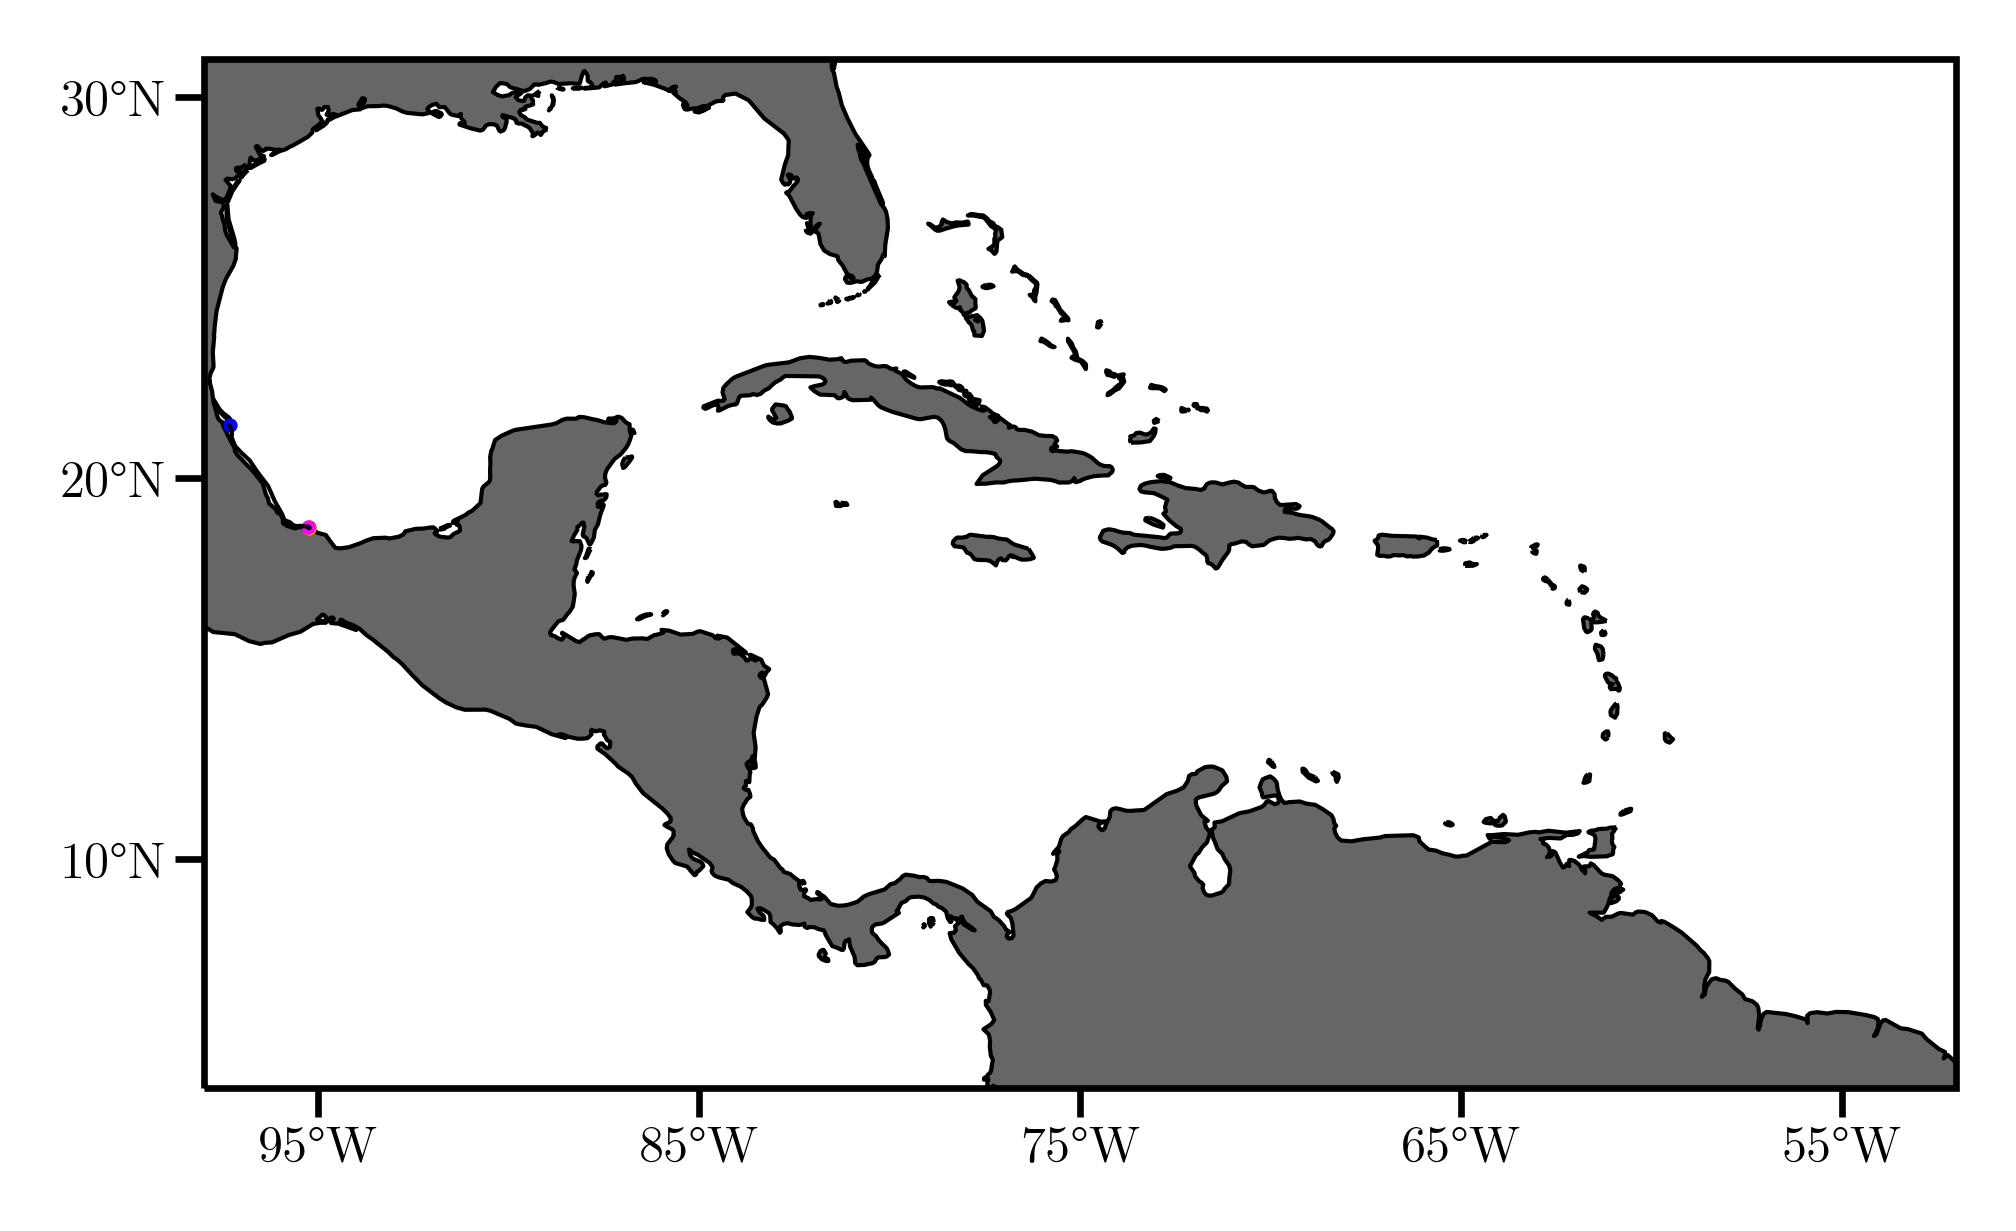

In [642]:
fig = plt.figure(dpi=600, figsize=fsh)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

geo_map(ax)

c1d, c2d, c3d = 0,0,0
if len(c1):
    c1d = c1.iloc[0].days
if len(c2):
    c2d = c2.iloc[0].days
if len(c3):
    c3d = c3.iloc[0].days
    
max_time = max(max(c1d, c2d), c3d) + 14

# plot traj
ax.plot(lon[idx, :max_time], lat[idx, :max_time], linewidth=0.5, color='k')

# start/end points
ax.scatter(lon[idx, 0], lat[idx, 0], s=0.5, color='b')

if c1d:
    ax.scatter(lon[idx, c1d], lat[idx, c1d], s=0.5, color='firebrick')
if c2d:
    ax.scatter(lon[idx, c2d], lat[idx, c2d], s=0.5, color='darkorange')
if c3d:
    ax.scatter(lon[idx, c3d], lat[idx, c3d], s=0.5, color='magenta')

In [12]:
def season(date, nh = True):
    """
    North Hemisphere (nh): season = winter, spring, summer, fall [0,1,2,3]
    South Hemisphere: season = summer, fall, winter, spring [2,3,0,1]
    """
    month, day = date.month, date.day
    
    if (2, 21) <= (month, day) < (5, 20):    # nh spring
        return 1 if nh else 3
    elif (5, 20) <= (month, day) < (8, 21):  # nh summer
        return 2 if nh else 0
    elif (8, 21) <= (month, day) < (11, 21): # nh fall
        return 3 if nh else 1
    else:                                    # nh winter
        return 0 if nh else 2  

In [14]:
display(ds)

,release,land,cid0,lon0,lat0,mass0,days,cid1,lon1,lat1,mass1,beached
0,2010-01-01,1,208,-53.850037,5.812482,0.483,30,208,-54.073784,5.786664,0.475,2010-01-31
1,2010-01-01,1,208,-53.803942,5.812480,0.483,30,208,-54.058041,5.766476,0.475,2010-01-31
2,2010-01-01,1,208,-53.821440,5.804647,0.483,30,208,-54.010437,5.734316,0.475,2010-01-31
3,2010-01-01,1,208,-53.832107,5.869294,0.483,30,208,-54.110260,5.825024,0.475,2010-01-31
4,2010-01-01,1,208,-56.231911,6.026595,0.362,30,208,-56.776016,5.944695,0.356,2010-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...
1596073,2021-12-01,1,235,-80.134467,25.550736,0.057,30,235,-80.161263,25.853382,0.056,2021-12-31
1596074,2021-12-01,1,235,-89.974190,29.193899,0.130,30,235,-90.167816,29.177237,0.128,2021-12-31
1596075,2021-12-01,1,235,-94.550089,29.356141,0.300,30,235,-94.497681,29.595991,0.295,2021-12-31
1596076,2021-12-01,1,235,-89.433074,29.493441,0.378,30,235,-89.429070,29.767811,0.372,2021-12-31


In [13]:
# plot
ds = pd.read_csv('beachings_c3.csv', delimiter=', ', parse_dates=['release'])
ds['beached'] = [ds.release[i] + timedelta(days=int(ds.days.values[i])) for i in range(0, len(ds))]
ds['season'] = [season(d) for d in ds.beached]

/tmp/ipykernel_2453994/599372207.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ds = pd.read_csv('beachings_c3.csv', delimiter=', ', parse_dates=['release'])


In [14]:
ds_l = xr.open_dataset('../data/process/land_GLBv0.08.nc')
land = ds_l.land.values
plon = ds_l.plon.values # center of cell
plat = ds_l.plat.values
qlon = ds_l.qlon.values # corner of cell
qlat = ds_l.qlat.values 
ds_l.close()

# subsample
grid_f = 2
qlon = qlon[::grid_f]
qlat = qlat[::grid_f]
plon = np.convolve(qlon, [0.5, 0.5], mode='valid')
plat = np.convolve(qlat, [0.5, 0.5], mode='valid')

### summed into qlon,qlat boxes

In [15]:
ret_c = stats.binned_statistic_2d(ds['lon1'].values, ds['lat1'].values, 
                                  ds['mass1'].values, 
                                  statistic='sum', 
                                  bins=[qlon, qlat])
beached_mass = ret_c.statistic.T

### summed into closest coastal box

In [16]:
@nb.njit
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    """
    lon1, lat1 = np.radians(lon1), np.radians(lat1)
    lon2, lat2 = np.radians(lon2), np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    # distance
    earthRadius = 6371 # km
    d = 2 * np.arcsin(np.sqrt(a)) * earthRadius # km
    return d

In [17]:
# this is ugly and I'm sure there is a function for this
# but I could not find quickly and got annoyed
land_sub = np.zeros((len(plat), len(plon)), dtype='bool')
for i in range(0, len(plat)):
    for j in range(0, len(plon)):
        ri = slice(i*grid_f, (i+1)*grid_f)
        rj = slice(j*grid_f, (j+1)*grid_f)
        land_sub[i,j] = True if np.mean(land[ri,rj]) > 0 and np.mean(land[ri,rj]) < 1 else False

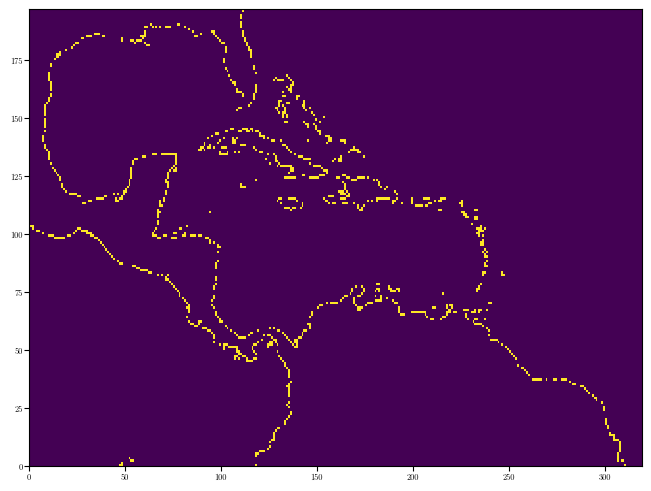

In [18]:
plt.pcolormesh(land_sub)

In [19]:
gplon, gplat = np.meshgrid(plon, plat)
gi, gj = np.where(land_sub)
land_lon, land_lat = gplon[land_sub], gplat[land_sub]

In [20]:
coastal_beached_mass = np.zeros_like(land_sub, dtype='float')

for i in range(0, len(ds['lon1'])):
    d = haversine(ds['lon1'][i], ds['lat1'][i], land_lon, land_lat)
    k = np.argmin(d) # closest land box
    coastal_beached_mass[gi[k],gj[k]] += ds['mass1'][i] # (i,j) -> (gi[k], gj[k])

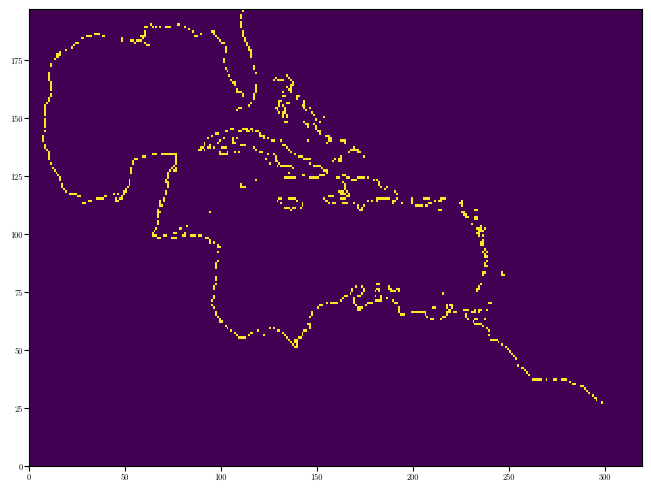

In [21]:
plt.pcolormesh(coastal_beached_mass>0)

In [22]:
np.max(beached_mass)

96056.14500000344

In [23]:
def radius(mass):
    categories = np.array([0, 10, 100, 1000, 10000, 100000])
    size = np.array([0.75, 1.0, 2.0, 3.0, 4.0, 7.0])/8
    arg = np.array([np.argmin(np.abs(m-categories)) for m in mass])
    return arg+0.5, size[arg]

In [24]:
nnz = np.where(beached_mass)
colors, scaled_mass = radius(beached_mass[nnz])

In [25]:
np.sum(colors == 0.5)

413

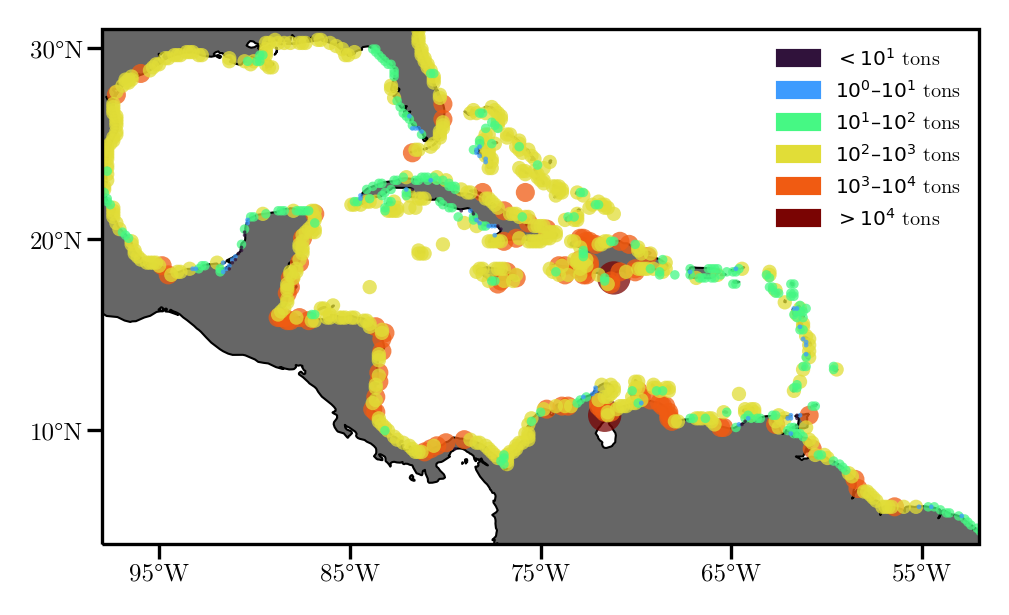

In [26]:
fig = plt.figure(dpi=300, figsize=fsh)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')

geo_map(ax)
    
#a = ax.scatter(plon[nnz[1]], plat[nnz[0]], 
#           s=np.exp(beached_mass[nnz]/(0.20*np.nanmax(beached_mass))), 
#          c=beached_mass[nnz], lw=2, marker='o',
#          )

#nnz = np.where(beached_mass)
#colors, scaled_mass = radius(beached_mass[nnz])
nnz = np.where(coastal_beached_mass)
colors, scaled_mass = radius(coastal_beached_mass[nnz])

patches = []
for x1, y1, r in sorted(zip(plon[nnz[1]], plat[nnz[0]], scaled_mass), key = lambda x: x[2], reverse=True):
    circle = Circle((x1, y1), r)
    #circle = Wedge((x1, y1), r, 0, 360, width=0.1)
    patches.append(circle)

cmap_name = plt.cm.turbo
     
p = PatchCollection(patches, alpha=0.75, cmap=cmap_name)
p.set_array(sorted(colors, reverse=True))
p.set_clim([np.min(colors), np.max(colors)])
ax.add_collection(p)

handles = []
handles.append(Polygon([(0,0),(5,0)], color=cmap_name(p.norm(np.min(colors))), label=f'$<10^{1}$ tons'))
for i,c in enumerate(np.unique(colors)[1:-1]):
    handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap_name(p.norm(c)), label=f'$10^{i}–10^{i+1}$ tons'))
handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap_name(p.norm(np.max(colors))), label=f'$>10^{i+1}$ tons'))
ax.legend(handles=handles, frameon=False, fontsize='x-small')  

fig.savefig(f'figures/hotspot_c3.png', format='png', dpi=600)

# seasonality

In [27]:
coastal_beached_mass_seasons = np.zeros((4, land_sub.shape[0], land_sub.shape[1]), dtype='float')

for i in range(0, len(ds['lon1'])):
    d = haversine(ds['lon1'][i], ds['lat1'][i], land_lon, land_lat)
    k = np.argmin(d) # closest land box
    coastal_beached_mass_seasons[ds['season'][i]][gi[k],gj[k]] += ds['mass1'][i] # (i,j) -> (gi[k], gj[k])

In [28]:
np.sum(coastal_beached_mass)

2357007.068999998

In [29]:
# this has to match the previous value
np.sum(coastal_beached_mass_seasons)

2357007.069000001

In [30]:
coastal_beached_mass_seasons.shape

(4, 197, 319)

In [31]:
np.max(coastal_beached_mass_seasons, axis=(1,2))

array([22186.925, 29389.975, 26431.04 , 20680.647])

In [32]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']

def radius_season(mass):
    categories = np.array([0, 10, 100, 1000, 10000])
    size = np.array([1.0, 2.0, 3.0, 4.0, 7.0])/8
    arg = np.array([np.argmin(np.abs(m-categories)) for m in mass])
    return arg+0.5, size[arg]

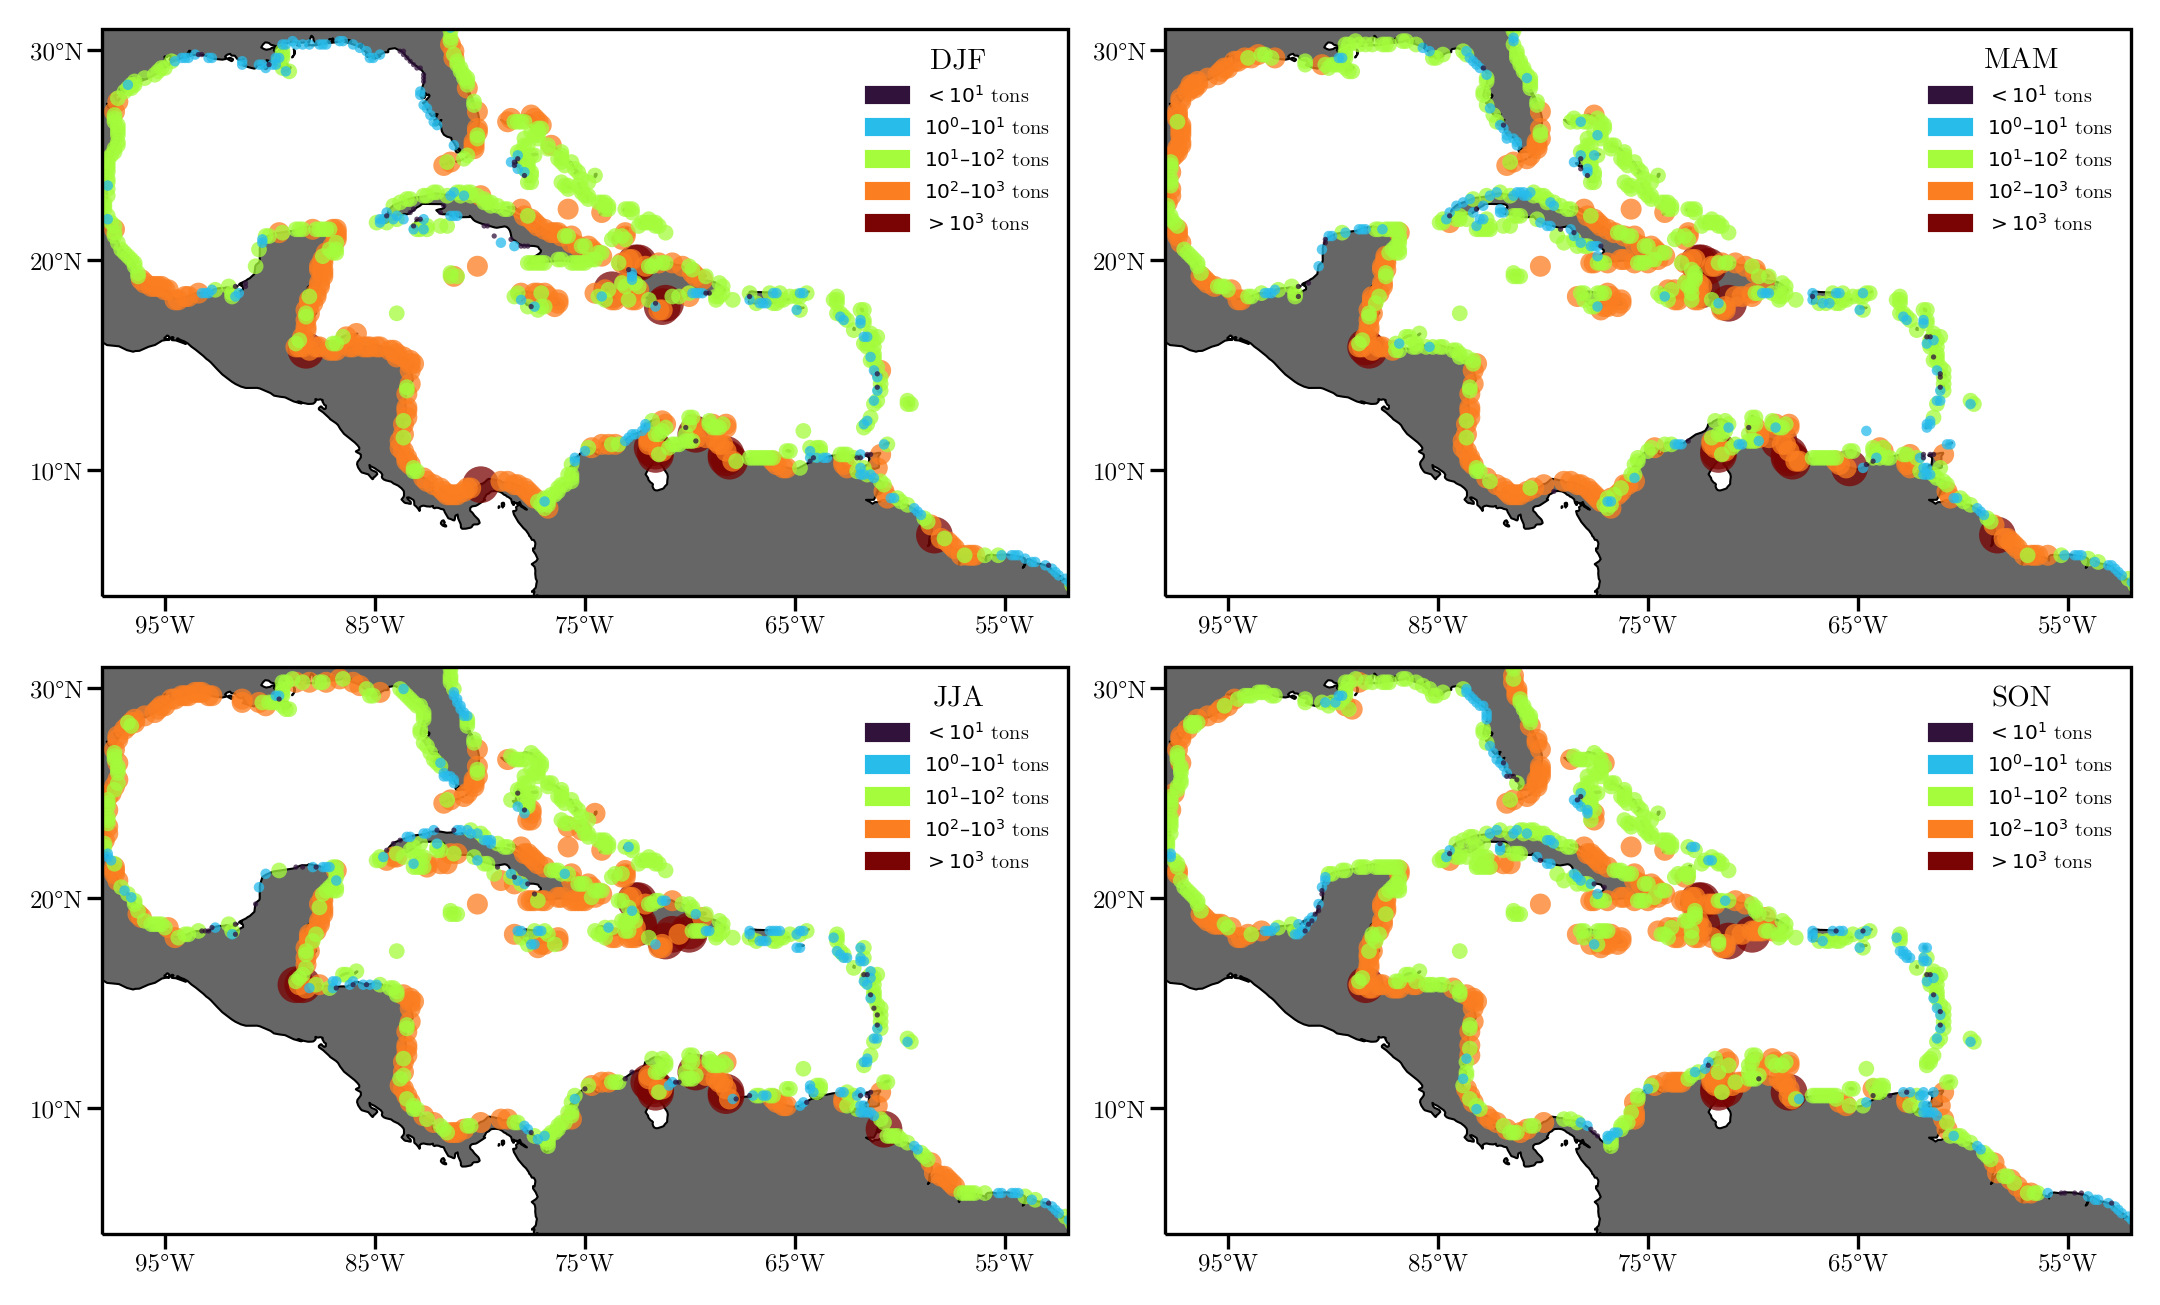

In [33]:
colors = []
scaled_mass = []

fig = plt.figure(dpi=300, figsize=(fs[0],0.6*fs[0]))
axes = create_axis(fig, 2, 2, proj=ccrs.PlateCarree())

for s, ax in enumerate(axes):
    geo_map(ax)

    #a = ax.scatter(plon[nnz[1]], plat[nnz[0]], 
    #           s=np.exp(beached_mass[nnz]/(0.20*np.nanmax(beached_mass))), 
    #          c=beached_mass[nnz], lw=2, marker='o',
    #          )

    #nnz = np.where(beached_mass)
    #colors, scaled_mass = radius(beached_mass[nnz])
    nnz = np.where(coastal_beached_mass_seasons[s])
    colors_s, scaled_mass_s = radius_season(coastal_beached_mass_seasons[s][nnz])
    
    # list
    colors.append(colors_s)
    scaled_mass.append(scaled_mass_s)

    patches = []
    for x1, y1, r in sorted(zip(plon[nnz[1]], plat[nnz[0]], scaled_mass_s), key = lambda x: x[2], reverse=True):
        circle = Circle((x1, y1), r)
        #circle = Wedge((x1, y1), r, 0, 360, width=0.1)
        patches.append(circle)

    cmap_name = plt.cm.turbo

    p = PatchCollection(patches, alpha=0.75, cmap=cmap_name)
    p.set_array(sorted(colors_s, reverse=True))
    p.set_clim([np.min(colors_s), np.max(colors_s)])
    ax.add_collection(p)
    
    #ax.set_title(f"Hotspots in {seasons[s]}")

    handles = []
    handles.append(Polygon([(0,0),(5,0)], color=cmap_name(p.norm(np.min(colors_s))), label=f'$<10^{1}$ tons'))
    for i,c in enumerate(np.unique(colors_s)[1:-1]):
        handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap_name(p.norm(c)), label=f'$10^{i}–10^{i+1}$ tons'))
    handles.append(Polygon([(0,0),(10,0),(0,-10)], color=cmap_name(p.norm(np.max(colors_s))), label=f'$>10^{i+1}$ tons'))
    ax.legend(handles=handles, frameon=False, fontsize='x-small')  
    ax.get_legend().set_title(seasons[s])
    
fig.savefig(f'figures/hotspot_seasonality_c3.png', format='png', dpi=600)